# We have to predict number of visitors on a prticular date for a given Restaurant ID. # 

## importing libraries ##

In [1]:
# importing libraries
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xg
import lightgbm as lgb
from matplotlib.pyplot import hist
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


## reading files ##

In [2]:
# we will train our model using all these files
yom_reserve = pd.read_csv('../input/ummmmmmmm/yom_reserve.csv')
chw_reserve = pd.read_csv('../input/ummmmmmmm/chw_reserve.csv')
yom_storeInfo = pd.read_csv('../input/ummmmmmmm/yom_store_info.csv')
chw_storeInfo = pd.read_csv('../input/ummmmmmmm/chw_store_info.csv')
dateInfo = pd.read_csv('../input/ummmmmmmm/date_info.csv')
ID_relation = pd.read_csv('../input/ummmmmmmm/store_id_relation.csv')
trainingFile = pd.read_csv('../input/ummmmmmmm/train.csv')
# print(trainingFile['visit_date'])
# yom_reserve.plot(x = 'yom_store_id', y = 'reserve_visitors', style = 'o')
# final testing of our model will happen on the testing file

testingFile = pd.read_csv('../input/ummmmmmmm/test.csv')
# yom_reserve.head()

## checking null (NAN) values ##

In [3]:
Dataframes = [yom_reserve, chw_reserve, yom_storeInfo, chw_storeInfo, dateInfo, ID_relation]
for data_frame in Dataframes:
    print(data_frame.isna().sum(),'\n')
    # print(data_frame.isnull().sum(),'\n')
    # print(data_frame.describe(),'\n')

yom_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64 

chw_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64 

yom_store_id      0
yom_genre_name    0
yom_area_name     0
latitude          0
longitude         0
dtype: int64 

chw_store_id      0
chw_genre_name    0
chw_area_name     0
latitude          0
longitude         0
dtype: int64 

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64 

chw_store_id    0
yom_store_id    0
dtype: int64 



      longitude   latitude  visitors
0    130.195555  33.557320     27674
1    130.348436  33.581941     35712
2    130.350764  33.580827     18424
3    130.369976  33.575686     29702
4    130.392813  33.589216    334433
..          ...        ...       ...
103  141.353957  43.056819      3062
104  141.474789  43.036408     12741
105  142.364819  43.770635     73973
106  143.197959  42.994143      3314
107  144.273398  44.020632     21426

[108 rows x 3 columns]


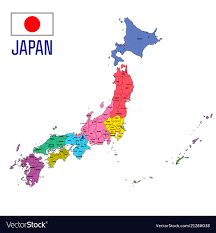

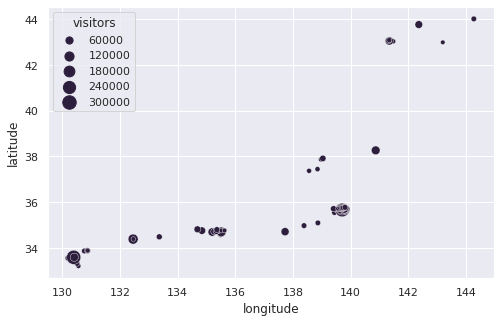

In [4]:
cols = chw_storeInfo[['chw_store_id','longitude','latitude']]
merged_df = pd.merge(trainingFile,cols,on='chw_store_id',how='inner')
merged_df = merged_df[['longitude','latitude','visitors']]
merged_df['average'] = (merged_df['longitude']+merged_df['latitude'])/2
p = merged_df.sort_values(by ='average')
p = p.drop('average',axis =1)
p_ = p.groupby(['longitude','latitude'])['visitors'].sum()

p_ = p_.reset_index() 
# p_=p_.pivot("longitude","latitude","visitors") 
print(p_)
p_= p_.sort_values(by = 'latitude')
sns.set(rc={'figure.figsize':(8,5)})
sns.scatterplot(data=p_, x="longitude", y="latitude", hue="visitors" , size = "visitors", sizes=(20,200), hue_norm=(0, 7))

from IPython.display import Image
from IPython.core.display import HTML 

Image(filename= "../input/aaaaaa/japan.png", width = 496, height = 319)

## just creating columns in data frames ##

Plot between Date and Total number of reserve visitors on that date


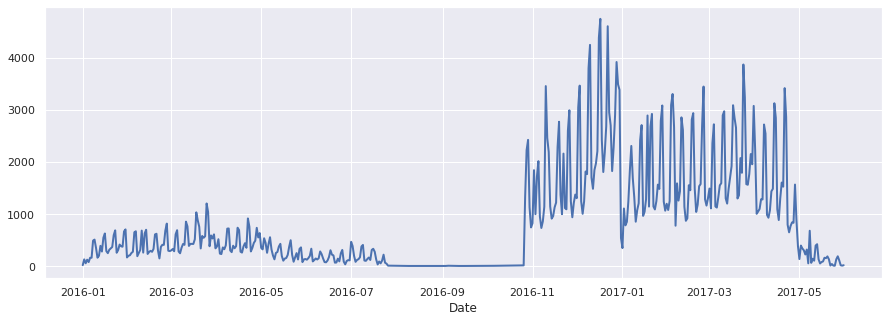

In [5]:
chwRes = chw_reserve.copy()
yomRes = yom_reserve.copy()

# we are decomposing date_time into two components month and date.
chwRes['Month'] = pd.to_datetime(chwRes['visit_datetime']).dt.month
chwRes['Date'] = pd.to_datetime(chwRes['visit_datetime']).dt.date
chwRes['Hour'] = pd.to_datetime(chwRes['visit_datetime']).dt.hour


yomRes['Month'] = pd.to_datetime(yomRes['visit_datetime']).dt.month
yomRes['Date'] = pd.to_datetime(yomRes['visit_datetime']).dt.date
yomRes['Hour'] = pd.to_datetime(yomRes['visit_datetime']).dt.hour

chwGroup_DATE = chwRes.groupby(['Date']).sum()
yomGroup_DATE = yomRes.groupby(['Date']).sum()

chwGroup_MONTH = chwRes.groupby(['Month']).sum()
yomGroup_MONTH = yomRes.groupby(['Month']).sum()

chwGroup_TIME = chwRes.groupby(['Hour']).sum()
yomGroup_TIME = yomRes.groupby(['Hour']).sum()

# chwGroup_DATE
print('Plot between Date and Total number of reserve visitors on that date')
sns.set(rc={'figure.figsize':(15,5)})
chwGroup_DATE['reserve_visitors'].plot(linewidth=2);
# chwGroup_DATE

In [6]:
# dropping columns month and hour 
chwGroup_DATE.drop(['Month', 'Hour'], axis = 1, inplace= True)
yomGroup_DATE.drop(['Month', 'Hour'], axis = 1, inplace= True)

## merging data frames w.r.t Date and then will calulate total number of reserve visitors ##
## on that particular date including all the restaurants in both chwiggy and yomato ##

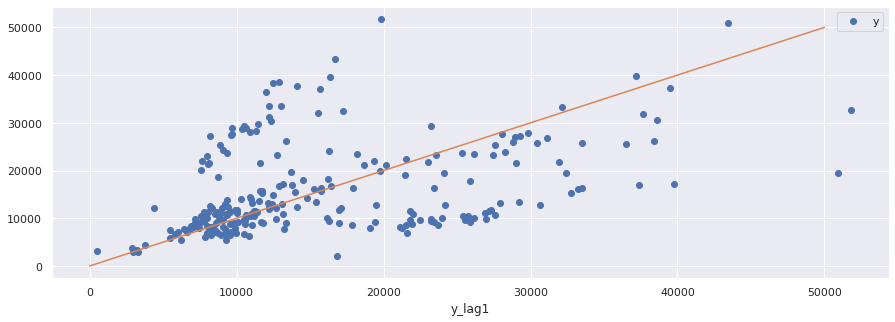

Correlation value between columns of number of visitors on a day and number of visitors a day back 0.42919005376311925


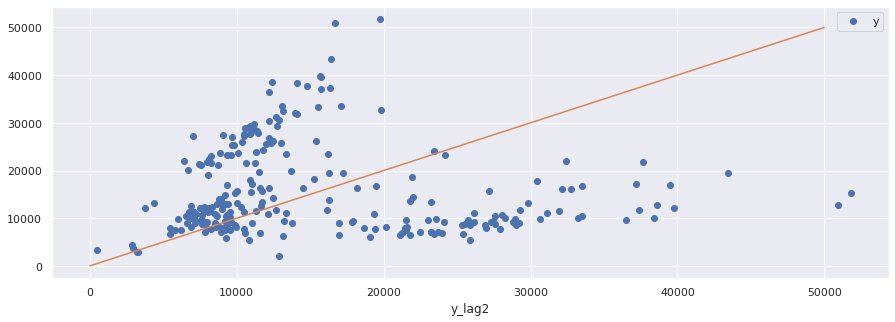

Correlation value between columns of number of visitors on a day and number of visitors 2 days back -0.06984135921854394
From both the graphs, no trend is observed, here y is total number of visitors


In [7]:
date_VS_resVis = pd.merge(chwGroup_DATE,yomGroup_DATE,on='Date',how='outer')
date_VS_resVis.sort_values(by = 'Date')
date_VS_resVis["total_res_vis"] = date_VS_resVis['reserve_visitors_y'] + date_VS_resVis['reserve_visitors_x']
date_VS_resVis
date_VS_resVis.drop(['reserve_visitors_y', 'reserve_visitors_x'], axis = 1, inplace = True)
date_VS_resVis

# y is now column of total number of reserve visitors
y = date_VS_resVis.loc[:,'total_res_vis']
# print(date_VS_resVis)
dataFrame_temp = pd.DataFrame({
    'y': y,
    'y_lag1': y.shift(1),
    'y_lag2': y.shift(2),    
})
dataFrame_temp.head()

# this plot will tell us how the number of reserve visitors on a particular day
# is dependent on the previous day
dataFrame_temp.plot(x='y_lag1', y = 'y', style = 'o')
X = np.linspace(1, 50000)
Y = np.linspace(1, 50000)
plt.plot(X, Y)
plt.show()
print('Correlation value between columns of number of visitors on a day and number of visitors a day back',dataFrame_temp['y'].corr(dataFrame_temp['y_lag1']))


# ..... dependent on two days back 
dataFrame_temp.plot(x='y_lag2', y = 'y', style = 'o')
X = np.linspace(1, 50000)
Y = np.linspace(1, 50000)
plt.plot(X, Y)
plt.show()
print('Correlation value between columns of number of visitors on a day and number of visitors 2 days back',dataFrame_temp['y'].corr(dataFrame_temp['y_lag2']))
dataFrame_temp['date_col'] = dataFrame_temp.index
dataFrame_temp

print('From both the graphs, no trend is observed, here y is total number of visitors')



## CHWIGGY ## 

 Number of reserve visitors vs Months


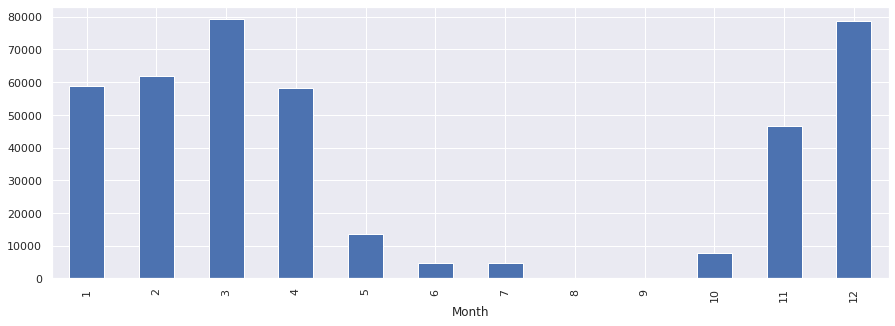

In [8]:
chwGroup_MONTH['reserve_visitors'].plot( kind = 'bar');
print(' Number of reserve visitors vs Months')
# chwGroup_MONTH

Number of reserve visitors vs Date


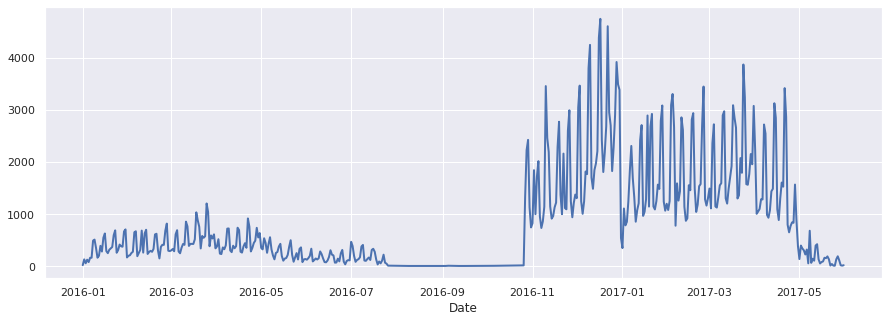

In [9]:
chwGroup_DATE['reserve_visitors'].plot(linewidth=2);
print('Number of reserve visitors vs Date')

We can see a rise in number of visitors between 5:00 pm to 9:00 pm


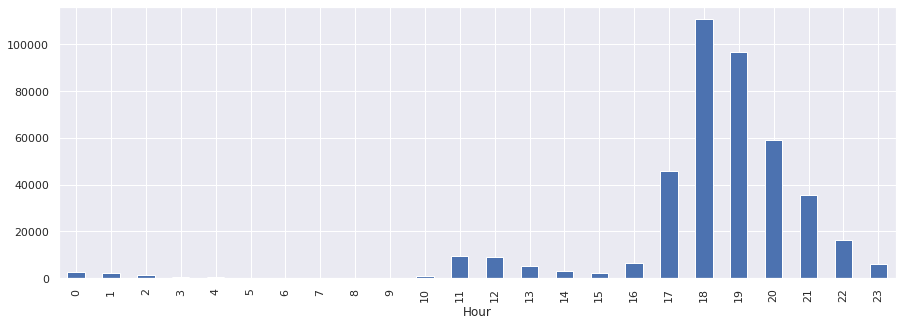

In [10]:
# histogram for hours vs no. of visitors
# print(chwGroup_TIME.index)
chwGroup_TIME['reserve_visitors'].plot(kind='bar',align='center')
print('We can see a rise in number of visitors between 5:00 pm to 9:00 pm')

## YOMATO ##

Number of reserve visitor vs Month


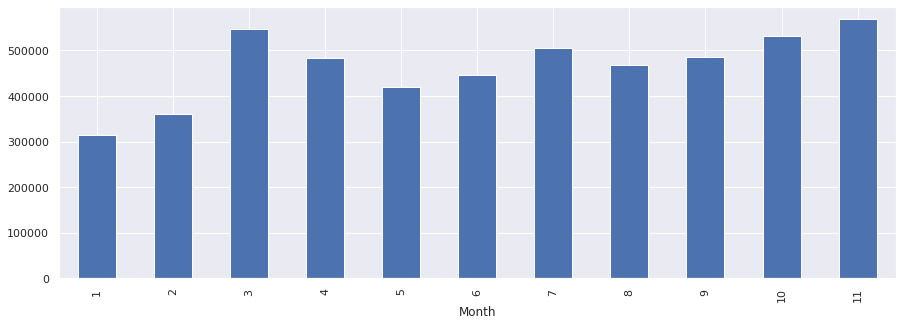

In [11]:
yomGroup_MONTH['reserve_visitors'].plot(kind = 'bar');
print('Number of reserve visitor vs Month')

Number of reserve visitors vs Date


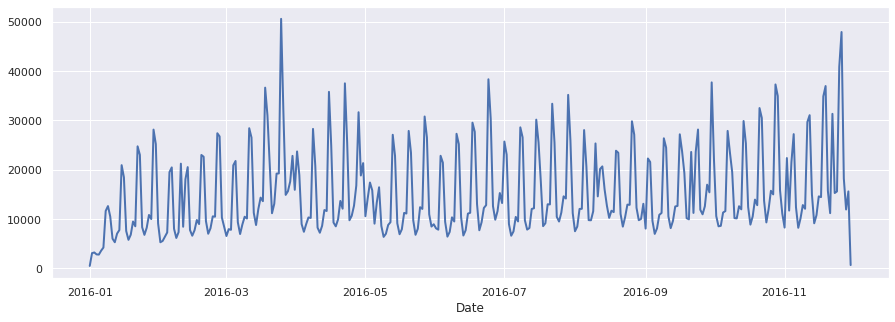

In [12]:
# chwGroup_TIME['Hour'] = chwGroup_TIME.index
# print(chwGroup_TIME)
yomGroup_DATE['reserve_visitors'].plot(linewidth=2);
print('Number of reserve visitors vs Date')
# plot between hour and no. of reserve visitors
# plt.plot(chwGroup_TIME['Hour'], chwGroup_TIME['reserve_visitors'])
# plt.xticks(chwGroup_TIME['Hour'])
# plt.show()

We can see a rise in number of visitors between 6:00 pm to 8:00 pm


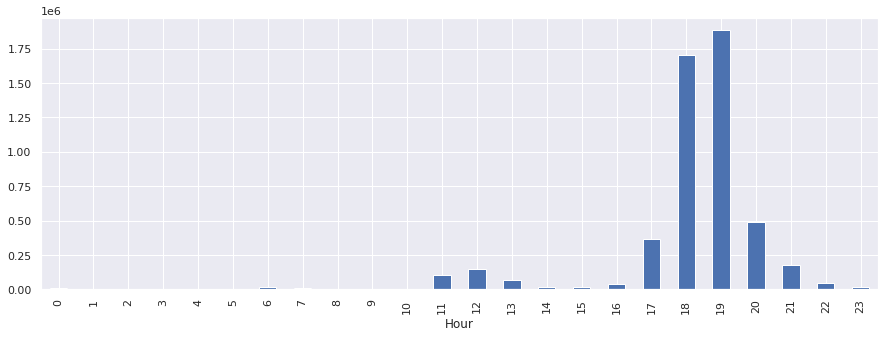

In [13]:
# histogram for hours vs no. of visitors
yomGroup_TIME['reserve_visitors'].plot(kind='bar',align='center')
print('We can see a rise in number of visitors between 6:00 pm to 8:00 pm')

## Genre name vs Reserve Visitors ##

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

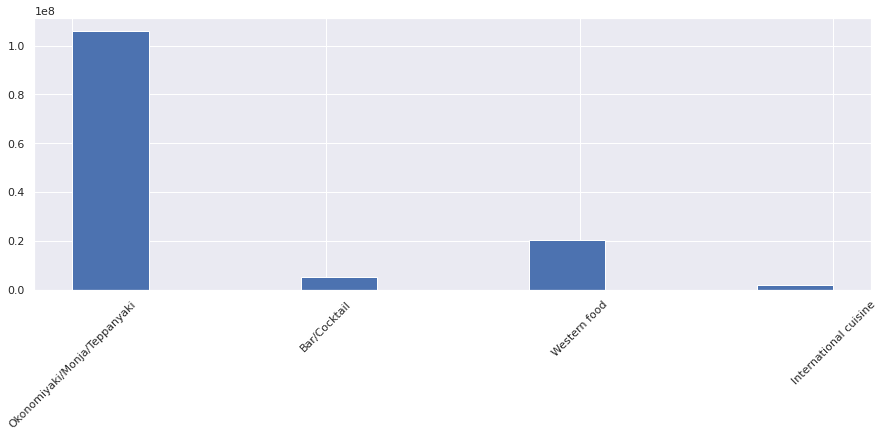

In [14]:
chw_merge_byID = pd.merge(chw_storeInfo,chw_reserve,on='chw_store_id',how='inner')
yom_merge_byID = pd.merge(yom_storeInfo,yom_reserve,on='yom_store_id',how='inner')

# chw_merge_byID.fillna()

# trainingFileCopy = trainingFile
# no need as number of visitors in training file includes reserve visitors also
# train_merged_byID = pd.merge(trainingFileCopy,chw_merge_byID,on='chw_store_id',how='inner')
# train_merged_byID = train_merged_byID.rename(columns={'chw_genre_name': 'genre_name'})


# changing column names to a common name, 'genre_name'
yom_merge_byID.rename(columns={'yom_genre_name': 'genre_name'}, inplace= True)
chw_merge_byID.rename(columns={'chw_genre_name': 'genre_name'}, inplace= True)



GENRE_NAME_merged = pd.merge(chw_merge_byID, yom_merge_byID, on='genre_name',how='inner')
# print(GENRE_NAME_merged.head())
total_reserve_visitors = GENRE_NAME_merged['reserve_visitors_y'] + GENRE_NAME_merged['reserve_visitors_x']
GENRE_NAME_merged["RESERVE_VISITORS"] = total_reserve_visitors


df = pd.DataFrame({
    'Genre': GENRE_NAME_merged['genre_name'],
    'total': GENRE_NAME_merged['RESERVE_VISITORS']
})
hist(df.Genre, weights=df.total)


plt.xticks(rotation = 45)




## Area name vs Reserve Visitors ##

In [15]:
# # print(chw_merge_byID)
# chw_merge_byID_forAREA = pd.merge(chw_storeInfo,chw_reserve,on='chw_store_id',how='inner')
# yom_merge_byID_forAREA = pd.merge(yom_storeInfo,yom_reserve,on='yom_store_id',how='inner')
# yom_merge_byID_forAREA.rename(columns={'yom_area_name': 'area_name'}, inplace= True)
# chw_merge_byID_forAREA.rename(columns={'chw_area_name': 'area_name'}, inplace= True)

# # print(chw_merge_byID['area_name'])
# AREA_NAME_merged = pd.merge(chw_merge_byID_forAREA, yom_merge_byID_forAREA, on='area_name',how='inner')
# # print(AREA_NAME_merged.head())
# total_reserve_visitors = AREA_NAME_merged['reserve_visitors_y'] + GENRE_NAME_merged['reserve_visitors_x']
# AREA_NAME_merged["RESERVE_VISITORS"] = total_reserve_visitors

# df2 = pd.DataFrame({
#     'Area': AREA_NAME_merged['area_name'],
#     'total': AREA_NAME_merged['RESERVE_VISITORS']
# })
# hist(df2.Area, weights=df2.total)

# plt.xticks(rotation = 45)
# # It tells us that there is no common area name 

                    chw_store_id  visit_datetime reserve_datetime  \
Date                                                                
2016-01-01  air_877f79706adbfb06  1/1/2016 19:00   1/1/2016 16:00   
2016-01-01  air_db4b38ebe7a7ceff  1/1/2016 19:00   1/1/2016 19:00   
2016-01-01  air_db4b38ebe7a7ceff  1/1/2016 19:00   1/1/2016 19:00   
2016-01-01  air_877f79706adbfb06  1/1/2016 20:00   1/1/2016 16:00   
2016-01-01  air_db80363d35f10926  1/1/2016 20:00    1/1/2016 1:00   

            reserve_visitors  
Date                          
2016-01-01                 1  
2016-01-01                 3  
2016-01-01                 6  
2016-01-01                 2  
2016-01-01                 5  


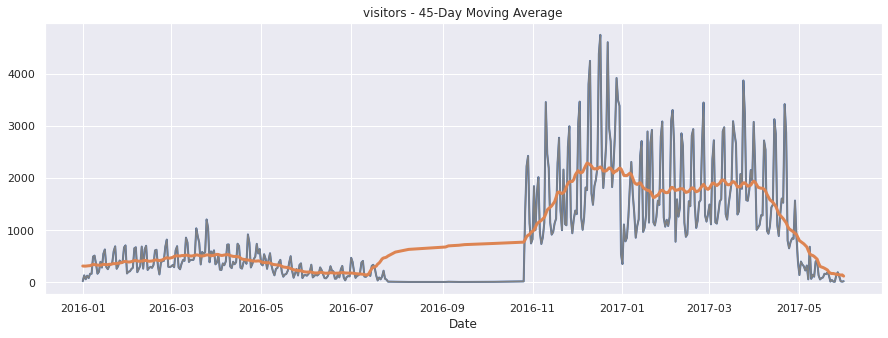

In [16]:

# chwRes = chw_reserve.copy()
# chwRes['Date'] = pd.to_datetime(chwRes['visit_datetime']).dt.date
# chwRes = chwRes.set_index("Date")

# # chwRes['Visitors'] = chwRes.iloc[:,3].rolling(window=35).mean()
# # chwRes['Visitors'].plot(linewidth=2);



# # print(chwRes.head)

# # 40 days
# chwRes.sort_values(by = 'Date', inplace= True)

# chwRes_grouped_by_date = chwRes.groupby('Date')['reserve_visitors'].sum()
# # training_for_trends.iloc[:,2]
# # chwRes['Visitors'] = chwRes.iloc[:,3].rolling(window=45).mean()
# # training_for_trends['Visitors'].plot(linewidth=2);

# # print(training_for_trends.head)
# # plt.figure(figsize=[15,10])
# # plt.grid(True)
# # plt.plot(training_for_trends['Visitors'],label='data')
# # plt.legend(loc=2)

# # 40 days
# moving_average2 = chwRes.rolling(
#     window=45,       # 40-day window
#     center=True,      # puts the average at the center of the window
#     min_periods=22,  # choose about half the window size
# ).mean()              # compute the mean (could also do median, std, min, max, ...)

# ax = chwRes.plot(style="-", color="0.5")
# moving_average2.plot(
#     ax=ax, linewidth=3, title="visitors - 45-Day Moving Average", legend=False,
# );


chwRes = chw_reserve.copy()
chwRes['Date'] = pd.to_datetime(chwRes['visit_datetime']).dt.date
chwRes = chwRes.set_index("Date")
print(chwRes.head())
# chwRes['Visitors'] = chwRes.iloc[:,3].rolling(window=35).mean()
# chwRes['Visitors'].plot(linewidth=2);



# print(chwRes.head)

# 40 days
chwRes.sort_values(by = 'Date', inplace= True)

chwRes_grouped_by_date = chwRes.groupby('Date')['reserve_visitors'].sum()
# training_for_trends.iloc[:,2]
# chwRes['Visitors'] = chwRes.iloc[:,3].rolling(window=45).mean()
chwRes_grouped_by_date.plot(linewidth=2);

# print(chwRes_grouped_by_date.head)
# plt.figure(figsize=[15,10])
# plt.grid(True)
# plt.plot(chwRes_grouped_by_date['reserve_visitors'],label='data')
# plt.legend(loc=2)

# 40 days
moving_average2 = chwRes_grouped_by_date.rolling(
    window=45,       # 40-day window
    center=True,      # puts the average at the center of the window
    min_periods=22,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = chwRes_grouped_by_date.plot(style="-", color="0.5")
moving_average2.plot(
    ax=ax, linewidth=3, title="visitors - 45-Day Moving Average", legend=False,
);


                    yom_store_id  visit_datetime reserve_datetime  \
Date                                                                
2016-01-01  hpg_c63f6f42e088e50f  1/1/2016 11:00    1/1/2016 9:00   
2016-01-01  hpg_dac72789163a3f47  1/1/2016 13:00    1/1/2016 6:00   
2016-01-01  hpg_c8e24dcf51ca1eb5  1/1/2016 16:00   1/1/2016 14:00   
2016-01-01  hpg_24bb207e5fd49d4a  1/1/2016 17:00   1/1/2016 11:00   
2016-01-01  hpg_25291c542ebb3bc2  1/1/2016 17:00    1/1/2016 3:00   

            reserve_visitors  
Date                          
2016-01-01                 1  
2016-01-01                 3  
2016-01-01                 2  
2016-01-01                 5  
2016-01-01                13  


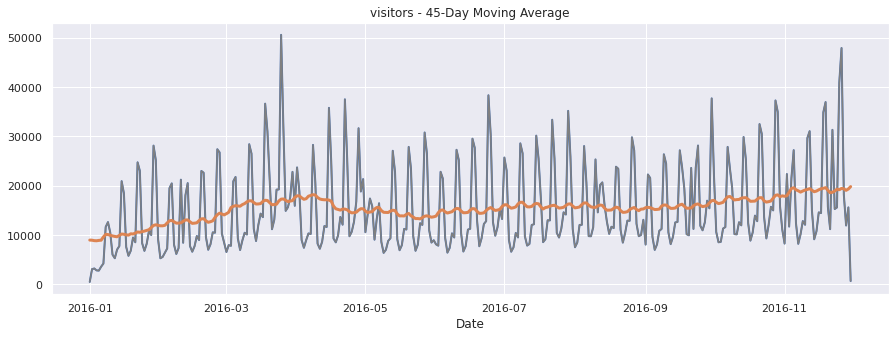

In [17]:
yomRes = yom_reserve.copy()
yomRes['Date'] = pd.to_datetime(yomRes['visit_datetime']).dt.date
yomRes = yomRes.set_index("Date")
print(yomRes.head())
# yomRes['Visitors'] = yomRes.iloc[:,3].rolling(window=35).mean()
# yomRes['Visitors'].plot(linewidth=2);



# print(yomRes.head)

# 40 days
yomRes.sort_values(by = 'Date', inplace= True)

yomRes_grouped_by_date = yomRes.groupby('Date')['reserve_visitors'].sum()
# training_for_trends.iloc[:,2]
# yomRes['Visitors'] = yomRes.iloc[:,3].rolling(window=45).mean()
yomRes_grouped_by_date.plot(linewidth=2);

# print(yomRes_grouped_by_date.head)
# plt.figure(figsize=[15,10])
# plt.grid(True)
# plt.plot(yomRes_grouped_by_date['reserve_visitors'],label='data')
# plt.legend(loc=2)

# 40 days
moving_average2 = yomRes_grouped_by_date.rolling(
    window=45,       # 40-day window
    center=True,      # puts the average at the center of the window
    min_periods=22,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = yomRes_grouped_by_date.plot(style="-", color="0.5")
moving_average2.plot(
    ax=ax, linewidth=3, title="visitors - 45-Day Moving Average", legend=False,
);

There is no such observation from the moving average plot graph between
Number of visitors and a window of 40 days


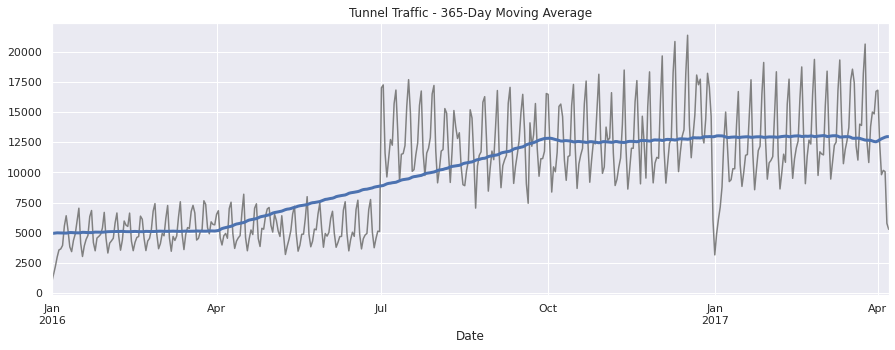

In [18]:
training_for_trends = trainingFile.copy()
training_for_trends['Date'] = pd.to_datetime(training_for_trends['visit_date'])
# training_for_trends.set_index("Date", inplace= True)
training_for_trends.sort_values(by = 'Date', inplace= True)

training_grouped_by_date = training_for_trends.groupby('Date')['visitors'].sum()
# training_for_trends.iloc[:,2]
training_for_trends['Visitors'] = training_for_trends.iloc[:,2].rolling(window=45).mean()
# training_for_trends['Visitors'].plot(linewidth=2);

# print(training_for_trends.head)
# plt.figure(figsize=[15,10])
# plt.grid(True)
# plt.plot(training_for_trends['Visitors'],label='data')
# plt.legend(loc=2)

# 40 days
moving_average2 = training_grouped_by_date.rolling(
    window=180,       # 40-day window
    center=True,      # puts the average at the center of the window
    min_periods=90,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = training_grouped_by_date.plot(style="-", color="0.5")
moving_average2.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);


print('There is no such observation from the moving average plot graph between')
print('Number of visitors and a window of 40 days')

0.05327008873546827
0.0536244583854365


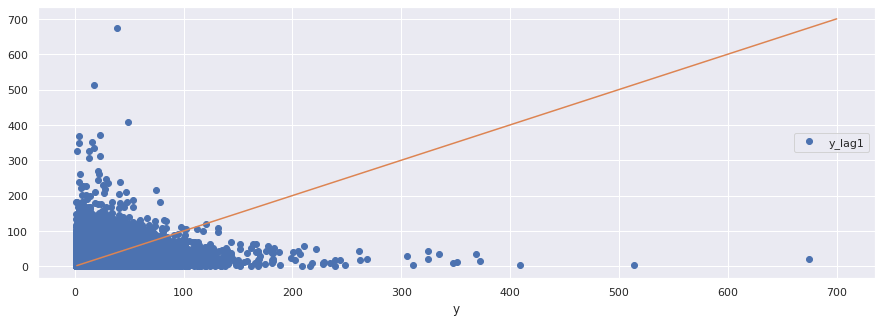

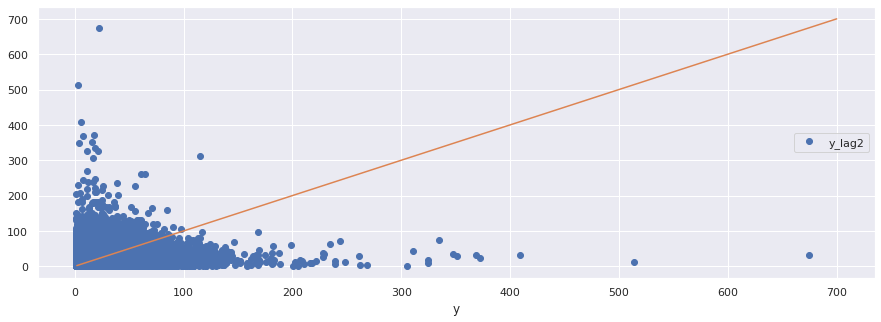

In [19]:
y = training_for_trends.loc[:,'visitors']

dataFrame_temp = pd.DataFrame({
    'y': y,
    'y_lag1': y.shift(1),
    'y_lag2': y.shift(2),    
})
dataFrame_temp.head()

# this plot will tell us how the number of visitors on a particular day
# is dependent on the previous day
dataFrame_temp.plot(x='y', y = 'y_lag1', style = 'o')
X = np.linspace(2 , 700)
Y = np.linspace(2 , 700)
plt.plot(X, Y)
print(dataFrame_temp['y_lag1'].corr(dataFrame_temp['y']))

# # ..... dependent on two days back 
dataFrame_temp.plot(x='y', y = 'y_lag2', style = 'o')
plt.plot(X, Y)

print(dataFrame_temp['y_lag2'].corr(dataFrame_temp['y']))
# dataFrame_temp['date_col'] = dataFrame_temp.index
# dataFrame_temp

# pd.plotting.lag_plot(dataFrame_temp['y'], lag=1)

# fig, ax = plt.subplots(1, 2, figsize=(12, 7))
# ax[0].plot(dataFrame_temp['y_lag1'],dataFrame_temp['y'])
# pd.plotting.lag_plot(dataFrame_temp['y_lag1'],lag=1,ax =ax[1])
# plt.show()
# print('From the graph below of y vs y_lag1, no trend is observed, here y is total number of visitors')



<AxesSubplot:xlabel='day_of_week'>

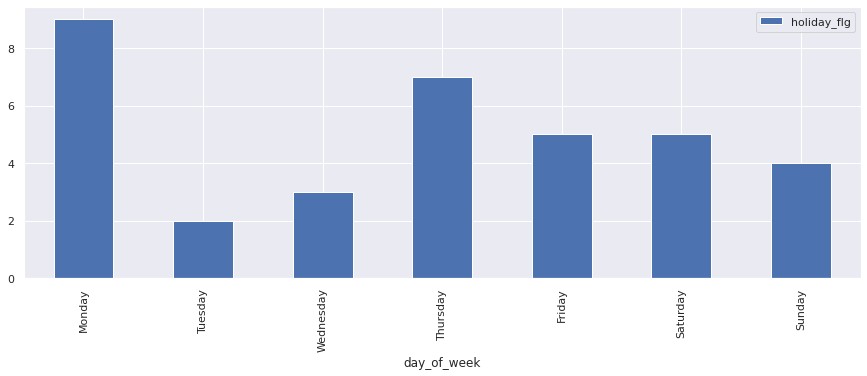

In [20]:
date_DATA = dateInfo.copy()

# holidays flag = 1
Holidays = date_DATA[date_DATA['holiday_flg'] == 1]
Holidays
days_ordering = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tmp = Holidays.groupby('day_of_week').sum().reindex(days_ordering)
# Holidays
tmp
tmp.plot(kind='bar',align='center')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Italian/French'),
  Text(1, 0, 'Cafe/Sweets'),
  Text(2, 0, 'Izakaya'),
  Text(3, 0, 'Western food'),
  Text(4, 0, 'Japanese food'),
  Text(5, 0, 'Asian'),
  Text(6, 0, 'Dining bar'),
  Text(7, 0, 'Yakiniku/Korean food'),
  Text(8, 0, 'Okonomiyaki/Monja/Teppanyaki'),
  Text(9, 0, 'Other'),
  Text(10, 0, 'Bar/Cocktail'),
  Text(11, 0, 'Creative cuisine'),
  Text(12, 0, 'International cuisine'),
  Text(13, 0, 'Karaoke/Party')])

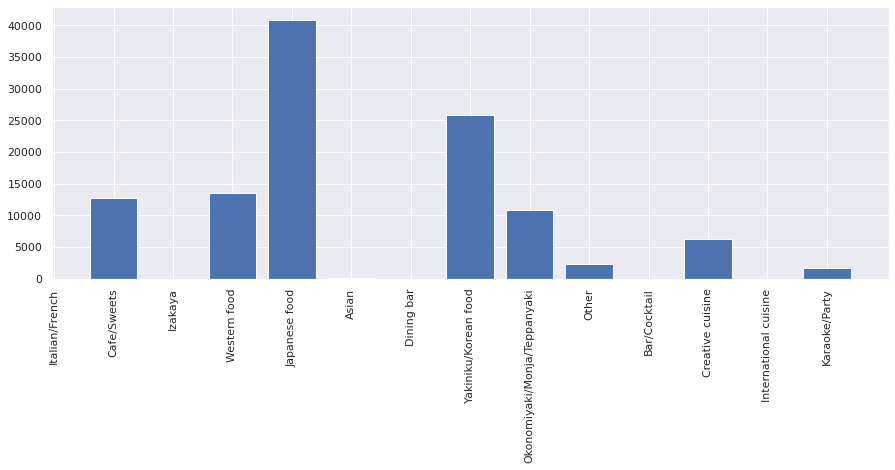

In [21]:
chiwgy_stores = chw_reserve.groupby('chw_store_id').sum()
yomato_stores = yom_reserve.groupby('yom_store_id').sum()


stores_merged_by_chw_id = pd.merge(chiwgy_stores,ID_relation,on="chw_store_id",how='outer')
# print(stores_merged_by_chw_id)

chw_store_info_tmp = chw_storeInfo.copy()

merged_all_hotels_by_chw_id = pd.merge(stores_merged_by_chw_id,chw_store_info_tmp,on='chw_store_id',how='inner')
merged_all_hotels_by_chw_id.head()

# merged_all_hotels_by_chw_id.set_index('chw_genre_name')


# merged_all_hotels_by_chw_id.plot(kind='bar',align='center')



genre_graph = {}
for index,row in merged_all_hotels_by_chw_id.iterrows():
    if(row['chw_genre_name'] in genre_graph):
        genre_graph[row['chw_genre_name']] += row['reserve_visitors']
    else:
        genre_graph[row['chw_genre_name']] = row['reserve_visitors']

plt.bar(range(len(genre_graph)), list(genre_graph.values()), align='center')
plt.xticks(range(len(genre_graph)), list(genre_graph.keys()))
plt.xticks(rotation=90)







(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]),
 [Text(0, 0, 'Tōkyō-to Chiyoda-ku Kudanminami'),
  Text(1, 0, 'Tōkyō-to Minato-ku Shibakōen'),
  Text(2, 0, 'Ōsaka-fu Ōsaka-shi Ōhiraki'),
  Text(3, 0, 'Hiroshima-ken Hiroshima-shi Kokutaijimachi'),
  Text(4, 0, 'Tōkyō-to Nerima-ku Toyotamakita'),
  Text(5, 0, 'Hokkaidō Sapporo-shi Kotoni 2 Jō'),
  Text(6, 0, 'Fukuoka-ken Fukuoka-shi Hakata Ekimae'),
  Text(7, 0, 'Tōkyō-to Kōtō-ku Tōyō'),
  Text(8, 0, 'Tōkyō-to Shinjuku-ku Kabukichō'),
  Text(9, 0, 'Tōkyō-to Kōtō-ku Tomioka'),
  Text(10, 0, 'Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike'),
  Text(11, 0, 'Tōkyō-to Chūō-ku Tsukiji'),
  Text(12, 0, 'Hokkaidō Sapporo-shi Minami 3 Jōnishi'),
  Text(13, 0, 'Niigata-ken

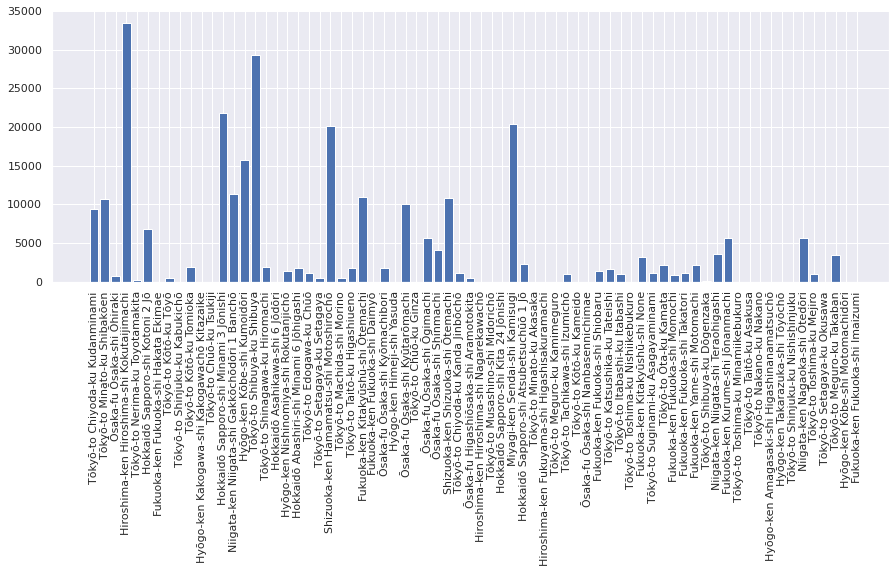

In [22]:

area_graph = {}
for index,row in merged_all_hotels_by_chw_id.iterrows():
    if(row['chw_area_name'] in area_graph):
        area_graph[row['chw_area_name']] += row['reserve_visitors']
    else:
        area_graph[row['chw_area_name']] = row['reserve_visitors']



plt.bar(range(len(area_graph)), list(area_graph.values()), align='center')
plt.xticks(range(len(area_graph)), list(area_graph.keys()))
plt.xticks(rotation=90)


In [23]:
store_info = {}

Hotel_relations = {}
# print(ID_relation)
for index, row in ID_relation.iterrows():
    # print(row['chw_store_id'])
    Hotel_relations[row['yom_store_id']] = row['chw_store_id']



for index,row in chw_storeInfo.iterrows():
    store_info[row['chw_store_id']] = [row['chw_genre_name'],row['chw_area_name'],row['latitude'],row['longitude']]



for index,row in yom_storeInfo.iterrows():
    if(row['yom_store_id'] in Hotel_relations):
        store_info[Hotel_relations[row['yom_store_id']]] = [row['yom_genre_name'],row['yom_area_name'],row['latitude'],row['longitude']] 

    else:
        store_info[row['yom_store_id']] = [row['yom_genre_name'],row['yom_area_name'],row['latitude'],row['longitude']]
        
        
    
# print(store_info)


# longitude, latitude, genre_name, area
main_data = trainingFile.copy()

latitudes = []
longitudes = []
area_names = []
genre_names = []

for index,row in main_data.iterrows():
    # print(row['visitors'])
    genre_name,area_name,latitude,longitude = store_info[row['chw_store_id']]
    # row['Latitude'] = latitude
    latitudes.append(latitude)
    longitudes.append(longitude)
    area_names.append(area_name)
    genre_names.append(genre_name)

main_data['Latitude'] = latitudes
main_data['Longitude'] = longitudes
main_data['Area_name'] = area_name
main_data['genre_name'] = genre_names
print(main_data)
main_data.isna().sum()






y = main_data['visitors']
main_data.drop(['visitors'], axis = 1, inplace = True)
# main_data.drop(['chw_store_id'], axis = 1, inplace = True)
label_encoder = preprocessing.LabelEncoder()


main_data_new = main_data.copy()
 
# Encode labels in column 'species'.
main_data['chw_store_id'] = label_encoder.fit_transform(main_data['chw_store_id'])
main_data['Area_name'] = label_encoder.fit_transform(main_data['Area_name'])
main_data['genre_name'] = label_encoder.fit_transform(main_data['genre_name'])
main_data['visit_date'] = label_encoder.fit_transform(main_data['visit_date'])
X_train, X_test, y_train, y_test = train_test_split(main_data, y, test_size = 0.20)



main_data_new['visitors'] = y


X_train
print(y)


                chw_store_id  visit_date  visitors   Latitude   Longitude  \
0       air_3561fd1c0bce6a95   8/25/2016         8  35.602201  139.697689   
1       air_26c5bbeb7bb82bf1   1/11/2017         9  35.752804  139.733481   
2       air_c1ff20617c54fee7   8/10/2016        13  35.637183  139.737998   
3       air_310e467e6e625004   3/10/2017        17  35.670651  139.771861   
4       air_671b4bea84dafb67    6/1/2016        34  35.658068  139.751599   
...                      ...         ...       ...        ...         ...   
215700  air_e053c561f32acc28   7/20/2016        27  43.770635  142.364819   
215701  air_74cf22153214064c   12/6/2016         3  34.799767  135.360073   
215702  air_287d2de7d3c93406  12/20/2016        24  35.724823  139.715963   
215703  air_2570ccb93badde68    7/6/2016        28  35.693840  139.703549   
215704  air_8e429650fcf7a0ae   8/15/2016         9  35.658068  139.751599   

                           Area_name             genre_name  
0       Tōkyō

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'Italian/French'),
  Text(1, 0, 'Cafe/Sweets'),
  Text(2, 0, 'International cuisine'),
  Text(3, 0, 'Japanese food'),
  Text(4, 0, 'Creative cuisine'),
  Text(5, 0, 'Bar/Cocktail'),
  Text(6, 0, 'Izakaya'),
  Text(7, 0, 'Yakiniku/Korean food'),
  Text(8, 0, 'Dining bar'),
  Text(9, 0, 'Spain Bar/Italian Bar'),
  Text(10, 0, 'Seafood'),
  Text(11, 0, 'Western food'),
  Text(12, 0, 'Japanese style'),
  Text(13, 0, 'Other'),
  Text(14, 0, 'Italian'),
  Text(15, 0, 'Okonomiyaki/Monja/Teppanyaki'),
  Text(16, 0, 'Japanese cuisine/Kaiseki'),
  Text(17, 0, 'Grilled meat'),
  Text(18, 0, 'Creation'),
  Text(19, 0, 'Japanese food in general'),
  Text(20, 0, 'Karaoke/Party'),
  Text(21, 0, 'Party'),
  Text(22, 0, 'Creative Japanese food'),
  Text(23, 0, 'Cafe'),
  Text(24, 0, 'Amusement bar'),
  Text(25, 0, 'Asian'),
  Text(26, 0, 'Steak/Hamburger/Curry')

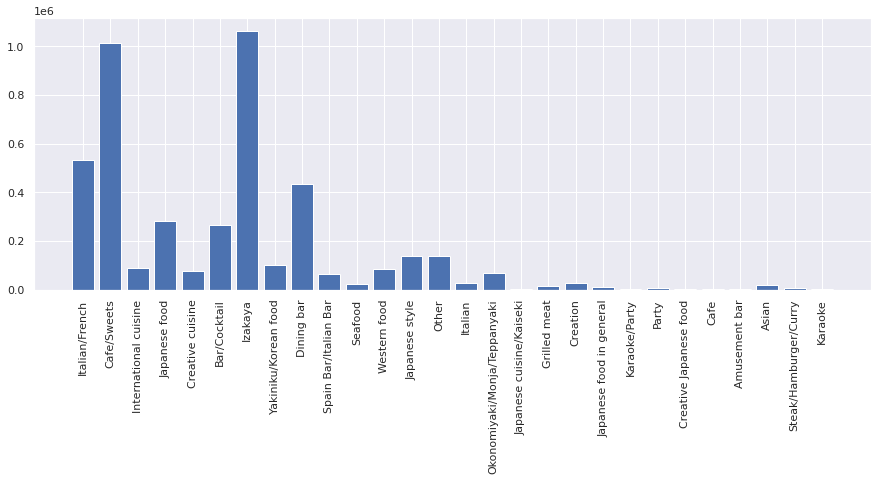

In [24]:
genre_name_vs_visitors = {}
# print(main_data_new.head())
for index,row in main_data_new.iterrows():
    # print(row)
    if row['genre_name'] in genre_name_vs_visitors:
        genre_name_vs_visitors[row['genre_name']] += row['visitors']
    else:
        genre_name_vs_visitors[row['genre_name']] = row['visitors']


# print(main_data_new['Area_name'].unique())

# print(genre_name_vs_visitors)

# # {area_name : visitors}
plt.bar(range(len(genre_name_vs_visitors)), list(genre_name_vs_visitors.values()), align='center')
plt.xticks(range(len(genre_name_vs_visitors)), list(genre_name_vs_visitors.keys()))
plt.xticks(rotation=90)

# Modifying features #

#### Reserve data of chwiggy and yomato ####

In [25]:
yom_chw_reserve = ID_relation.join(yom_reserve.set_index('yom_store_id'), on = 'yom_store_id')
yom_chw_reserve
yom_chw_reserve.drop(columns=['yom_store_id'], axis= 1, inplace= True)
temp_chw_reserve = chw_reserve.copy()
# # added all the information from chw_reserve dataset 
Reserve_Final_Data = pd.concat([temp_chw_reserve, yom_chw_reserve])
# # temp_chw_reserve
Reserve_Final_Data['visit_datetime'] = pd.to_datetime(Reserve_Final_Data['visit_datetime'])
Reserve_Final_Data['reserve_datetime'] = pd.to_datetime(Reserve_Final_Data['reserve_datetime'])

Reserve_Final_Data['visit_date'] = Reserve_Final_Data['visit_datetime'].apply(lambda x : str(x)[0:10])
Reserve_Final_Data['visit_date'] = pd.to_datetime(Reserve_Final_Data['visit_date'])

Reserve_Final_Data['hours_difference'] = Reserve_Final_Data['visit_datetime'].sub(Reserve_Final_Data['reserve_datetime'])
Reserve_Final_Data

# # it will give the difference in terms of hours 
Reserve_Final_Data['hours_difference'] = Reserve_Final_Data['hours_difference'].apply(lambda x : x/np.timedelta64(1, 'h'))

##### create hours_diiference gaps columns, like if they visited within 12 hrs after booking, after 24hrs etc #####

In [26]:
Reserve_Final_Data['12hrs'] = np.where(Reserve_Final_Data['hours_difference'] <= 12, Reserve_Final_Data['reserve_visitors'], 0)
Reserve_Final_Data['1.5days'] = np.where((Reserve_Final_Data['hours_difference'] > 12) & (Reserve_Final_Data['hours_difference'] <= 36), Reserve_Final_Data['reserve_visitors'], 0)
Reserve_Final_Data['2.5days'] = np.where((Reserve_Final_Data['hours_difference'] > 36) & (Reserve_Final_Data['hours_difference'] <= 60), Reserve_Final_Data['reserve_visitors'], 0)
Reserve_Final_Data['after_2.5days'] = np.where((Reserve_Final_Data['hours_difference'] > 60) & (Reserve_Final_Data['hours_difference'] <= 84) , Reserve_Final_Data['reserve_visitors'], 0)
Reserve_Final_Data['other'] = np.where((Reserve_Final_Data['hours_difference'] > 84) , Reserve_Final_Data['reserve_visitors'], 0)
# Reserve_Final_Data

In [27]:
group_list = ['chw_store_id', 'visit_date', 'reserve_visitors', '12hrs', '1.5days', '2.5days', 'after_2.5days','other']
Reserve_Final_Data = Reserve_Final_Data[group_list].groupby(['chw_store_id', 'visit_date'], as_index= False).sum()
Reserve_Final_Data

,chw_store_id,visit_date,reserve_visitors,12hrs,1.5days,2.5days,after_2.5days,other
0,air_00a91d42b08b08d9,2016-01-14,2,0,0,0,2,0
1,air_00a91d42b08b08d9,2016-01-15,4,0,0,0,0,4
2,air_00a91d42b08b08d9,2016-01-16,2,0,0,0,2,0
3,air_00a91d42b08b08d9,2016-01-22,2,0,0,0,2,0
4,air_00a91d42b08b08d9,2016-01-29,5,0,0,0,0,5
...,...,...,...,...,...,...,...,...
39679,air_fea5dc9594450608,2017-04-22,2,2,0,0,0,0
39680,air_fea5dc9594450608,2017-04-25,2,0,0,0,0,2
39681,air_fea5dc9594450608,2017-04-28,3,0,0,0,0,3
39682,air_fea5dc9594450608,2017-05-20,6,0,0,0,0,6


#### genre and area ####

In [28]:
def merge_area_and_genre(df):
    df = pd.merge(chw_genre_n_area_fix, df, how = 'left', left_on=['chw_genre_name', 'chw_area_name'], right_on = ['chw_genre_name', 'chw_area_name'])
    return df

In [29]:
Chw_rest_givenArea = chw_storeInfo.copy()
Chw_rest_givenArea = Chw_rest_givenArea[['chw_store_id', 'chw_area_name']].groupby(['chw_area_name'], as_index= False).count()
Chw_rest_givenArea.rename(columns={'chw_store_id' : 'Total_resto_inArea'}, inplace=True)
# Chw_rest_givenArea

In [30]:
# merge df with air_area_total_ret to get the total number of restaurants in an area with respect to store id
def merge_total_restaurants_in_area(df):
  df = pd.merge(df, Chw_rest_givenArea, how = 'left',left_on = ['chw_area_name'],right_on = ['chw_area_name'])
  return df

#### HOLIDAYS

In [31]:
holiday_features = dateInfo.copy()
holiday_features['next_day_holiday'] = np.zeros(holiday_features.shape[0])

holiday_features['next_day_holiday'].iloc[:-1] = holiday_features['holiday_flg'].copy().values[1:]
holiday_features.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,calendar_date,day_of_week,holiday_flg,next_day_holiday
0,2016-01-01,Friday,1,1.0
1,2016-01-02,Saturday,1,1.0
2,2016-01-03,Sunday,1,0.0
3,2016-01-04,Monday,0,0.0
4,2016-01-05,Tuesday,0,0.0


In [32]:
# one feature with either a holiday or weekend
weekend = ['Saturday', 'Sunday']
holiday_features['free_day'] = np.where(holiday_features['day_of_week'].isin(weekend) | holiday_features['holiday_flg'] == 1, 1, 0)
# holiday_features

In [33]:
# you can drop holiday_flg feature as we included this in free_day feature (redundancy)
holiday_features.drop(columns=['holiday_flg'], axis = 1, inplace= True)
holiday_features

,calendar_date,day_of_week,next_day_holiday,free_day
0,2016-01-01,Friday,1.0,1
1,2016-01-02,Saturday,1.0,1
2,2016-01-03,Sunday,0.0,1
3,2016-01-04,Monday,0.0,0
4,2016-01-05,Tuesday,0.0,0
...,...,...,...,...
512,2017-05-27,Saturday,0.0,1
513,2017-05-28,Sunday,0.0,1
514,2017-05-29,Monday,0.0,0
515,2017-05-30,Tuesday,0.0,0


In [34]:
# convert air store id + visit date into two separate columns
# divide date into separate features: date, month, day of week, week of year
def seperate_date(X):    
    
    
    # X['visit_date'] = pd.to_datetime(X['visit_date'],format= '%Y-%m-%d')
    X['visit_date_month'] =X.visit_date.dt.month
    X['visit_date_dayofw'] =X.visit_date.dt.dayofweek
    X['visit_date_year'] =X.visit_date.dt.year
    X['visit_date_dayofm'] =X.visit_date.dt.day
    X['weekofyear'] =X.visit_date.dt.weekofyear
    X.loc[X.weekofyear==53,'weekofyear'] =0 
    # X['id'] = X['chw_store_id'] + str('_') + X['visit_date']
    return X

In [35]:
def Normalization(df, cols):
#     df[cols].apply(lambda x : np.log1p(x))
    df[cols].apply(lambda x : (x - x.min()) / (x.max() - x.min()))
    return df

In [36]:
def merge_Coordinates(df): 
    df['sum_of_coordinates'] = df['latitude'] + df['longitude']
    df['sum_of_coordinates'] = df['sum_of_coordinates'].apply(lambda x: np.log1p(x))
    df['latitude_max_diff'] = df['latitude'].max() - df['latitude']
    df['longitude_max_diff'] = df['longitude'].max() - df['longitude']
#     df['latitude_min_diff'] = df['latitude'] - df['latitude'].min()
#     df['longitude_min_diff'] = df['longitude'] - df['longitude'].min()
    df['product_coordinates'] = df['longitude'] * df['latitude']
    return df

In [37]:
def split_area(df):
  df[['area1','area2','area3','4','5']]=df.chw_area_name.str.split(pat=' ',expand=True)
  df.drop(columns=['area3','4','5'],axis=1,inplace=True)
  return df

In [38]:
# merge dataframe with the calculated data -> mean median and max visitors as per restaurant
def add_calculated_data(data, calc_data):
    data = pd.merge(data, calc_data, how = 'left',left_on = ['chw_store_id', 'free_day'],right_on = ['chw_store_id', 'free_day'])
    return data

In [39]:
chw_area_total_ret = chw_storeInfo.copy()
chw_area_total_ret = chw_area_total_ret[['chw_store_id', 'chw_area_name']].groupby(['chw_area_name'], as_index = False).count()
chw_area_total_ret = chw_area_total_ret.rename(columns = {'chw_store_id': 'total_rt_in_area'})

In [40]:
chw_genre_total_ret = chw_storeInfo.copy()
chw_genre_total_ret = chw_genre_total_ret[['chw_store_id', 'chw_genre_name']].groupby(['chw_genre_name'], as_index = False).count()
chw_genre_total_ret = chw_genre_total_ret.rename(columns = {'chw_store_id': 'total_rt_in_genre'})

In [41]:
trainingFile_tmp = trainingFile.copy()
trainingFile_tmp['visit_date'] = pd.to_datetime(trainingFile_tmp['visit_date'])
# trainingFile_tmp.sort_values(by=['visit_date'], inplace=True)

print(trainingFile_tmp.isna().sum())

trainingFile_tmp = pd.merge(trainingFile_tmp, Reserve_Final_Data, how = 'left', left_on = ['chw_store_id', 'visit_date'], right_on = ['chw_store_id','visit_date'] )
trainingFile_tmp['reserve_visitors'].fillna(trainingFile_tmp['reserve_visitors'].mode()[0], inplace=True)
trainingFile_tmp

holiday_features['calendar_date'] = pd.to_datetime(holiday_features['calendar_date'])
# # print(trainingFile_tmp['visit_date'])
# # holiday_features['calendar_date']
training_with_dateInfo = trainingFile_tmp.join(holiday_features.set_index('calendar_date'), on = 'visit_date')
# trainingFile_tmp['visit_date'] = trainingFile['visit_date']
# # Both_DFs=pd.merge(df1,df2, how='left',left_on=['A','B'],right_on=['A','CC'])[['A','B','CC']]
# print(trainingFile_tmp.shape)

# print(Reserve_Final_Data.head())
training_with_dateInfo = seperate_date(training_with_dateInfo)

training_with_dateInfo = pd.merge(training_with_dateInfo, chw_storeInfo, how = 'left', on = ['chw_store_id'])
y = training_with_dateInfo['visitors']
y = np.log2(y)

training_with_dateInfo = split_area(training_with_dateInfo)
# one hot encoding of the area and genre columns for test set
dum=pd.get_dummies(training_with_dateInfo.area1)
dum2=pd.get_dummies(training_with_dateInfo.chw_genre_name)
frames=[training_with_dateInfo,dum,dum2]
training_with_dateInfo=pd.concat(frames,axis=1)

training_with_dateInfo = pd.merge(training_with_dateInfo, chw_area_total_ret, how = 'left', on = ['chw_area_name'])
training_with_dateInfo = pd.merge(training_with_dateInfo, chw_genre_total_ret, how = 'left', on = ['chw_genre_name'])


tmp = training_with_dateInfo.groupby('chw_genre_name').size()/len(training_with_dateInfo)
training_with_dateInfo.loc[:, "chw_genre_name"] = training_with_dateInfo['chw_genre_name'].map(tmp)

# print('unique : ', trainFile['chw_area_name'].unique)

tmp = training_with_dateInfo.groupby('chw_area_name').size()/len(training_with_dateInfo)
training_with_dateInfo.loc[:, "chw_area_name"] = training_with_dateInfo['chw_area_name'].map(tmp)


training_with_dateInfo['lag(visitors,1)'] = training_with_dateInfo['reserve_visitors'].shift(1)
training_with_dateInfo['lag(visitors,2)'] = training_with_dateInfo['reserve_visitors'].shift(2)
training_with_dateInfo['lag(visitors,3)'] = training_with_dateInfo['reserve_visitors'].shift(3)
training_with_dateInfo['lag(visitors,4)'] = training_with_dateInfo['reserve_visitors'].shift(4)
training_with_dateInfo['lag(visitors,5)'] = training_with_dateInfo['reserve_visitors'].shift(5)
training_with_dateInfo['lag(visitors,6)'] = training_with_dateInfo['reserve_visitors'].shift(6)


training_with_dateInfo['lead(visitors,1)'] = training_with_dateInfo['reserve_visitors'].shift(-1)
training_with_dateInfo['lead(visitors,2)'] = training_with_dateInfo['reserve_visitors'].shift(-2)
training_with_dateInfo['lead(visitors,3)'] = training_with_dateInfo['reserve_visitors'].shift(-3)
training_with_dateInfo['lead(visitors,4)'] = training_with_dateInfo['reserve_visitors'].shift(-4)
training_with_dateInfo['lead(visitors,5)'] = training_with_dateInfo['reserve_visitors'].shift(-5)


colsTonorm = ['sum_of_coordinates','latitude_max_diff','longitude_max_diff', 'latitude', 'longitude', 'visit_date_year', 'product_coordinates']

air_visit_wd = trainingFile_tmp.join(holiday_features.set_index('calendar_date'), on = 'visit_date')
mean_of_visitors = air_visit_wd[['visitors','chw_store_id','free_day']].copy().groupby(['chw_store_id','free_day'],as_index = False).mean()
mean_of_visitors.rename(columns = {'visitors': 'fd_mean_visitors'}, inplace= True)

median_of_visitors = air_visit_wd[['visitors','chw_store_id','free_day']].copy().groupby(['chw_store_id','free_day'],as_index = False).median()
median_of_visitors.rename(columns = {'visitors': 'fd_median_visitors'}, inplace = True)

# max visitors per restaurant
max_visitors = air_visit_wd[['visitors','chw_store_id','free_day']].copy().groupby(['chw_store_id','free_day'],as_index = False).max()
max_visitors.rename(columns = {'visitors': 'fd_max_visitors'}, inplace=True)

min_visitors = air_visit_wd[['visitors','chw_store_id','free_day']].copy().groupby(['chw_store_id','free_day'],as_index = False).min()
min_visitors.rename(columns = {'visitors': 'fd_mode_visitors'}, inplace=True)

training_with_dateInfo = add_calculated_data(training_with_dateInfo, mean_of_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, median_of_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, max_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, min_visitors)


#......................................#
mean_1 = training_with_dateInfo[['visitors','chw_store_id','visit_date_dayofw']].groupby(['chw_store_id','visit_date_dayofw']).agg('mean').reset_index()
mean_1.columns = ['chw_store_id','visit_date_dayofw','store_dayofw_mean_visitors']

median_1 = training_with_dateInfo[['visitors','chw_store_id','visit_date_dayofw']].groupby(['chw_store_id','visit_date_dayofw']).agg('median').reset_index()
median_1.columns = ['chw_store_id','visit_date_dayofw','store_dayofw_median_visitors']

max_1 = training_with_dateInfo[['visitors','chw_store_id','visit_date_dayofw']].groupby(['chw_store_id','visit_date_dayofw']).agg('max').reset_index()
max_1.columns = ['chw_store_id','visit_date_dayofw','store_dayofw_max_visitors']

# min_1 = training_with_dateInfo[['visitors','chw_store_id','visit_date_dayofw']].groupby(['chw_store_id','visit_date_dayofw']).agg('min').reset_index()
# min_1.columns = ['chw_store_id','visit_date_dayofw','store_dayofw_min_visitors']

mean_2 = training_with_dateInfo[['visitors','chw_store_id']].groupby('chw_store_id').agg('mean').reset_index()
mean_2.columns = ['chw_store_id','store_mean_visitors']

median_2 = training_with_dateInfo[['visitors','chw_store_id']].groupby('chw_store_id').agg('median').reset_index()
median_2.columns = ['chw_store_id','store_median_visitors']

max_2 = training_with_dateInfo[['visitors','chw_store_id']].groupby('chw_store_id').agg('max').reset_index()
max_2.columns = ['chw_store_id','store_max_visitors']

# min_2 = training_with_dateInfo[['visitors','chw_store_id']].groupby('chw_store_id').agg('min').reset_index()
# min_2.columns = ['chw_store_id','store_min_visitors']

mean_3 = training_with_dateInfo[['visitors','chw_store_id','visit_date_month']].groupby(['chw_store_id','visit_date_month']).agg('mean').reset_index()
mean_3.columns = ['chw_store_id','visit_date_month','store_month_mean_visitors']

median_3 = training_with_dateInfo[['visitors','chw_store_id','visit_date_month']].groupby(['chw_store_id','visit_date_month']).agg('median').reset_index()
median_3.columns = ['chw_store_id','visit_date_month','store_month_median_visitors']

max_3 = training_with_dateInfo[['visitors','chw_store_id','visit_date_month']].groupby(['chw_store_id','visit_date_month']).agg('max').reset_index()
max_3.columns = ['chw_store_id','visit_date_month','store_month_max_visitors']

# min_3 = training_with_dateInfo[['visitors','chw_store_id','visit_date_month']].groupby(['chw_store_id','visit_date_month']).agg('min').reset_index()
# min_3.columns = ['chw_store_id','visit_date_month','store_dayofw_min_visitors']
# ...............................#

training_with_dateInfo = training_with_dateInfo.merge(mean_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_1,on=['chw_store_id','visit_date_dayofw'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(mean_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_2,on=['chw_store_id'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(mean_3,on=['chw_store_id','visit_date_month'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_3,on=['chw_store_id','visit_date_month'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_3,on=['chw_store_id','visit_date_month'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_3,on=['chw_store_id','visit_date_month'],how='left')


training_with_dateInfo.drop(columns = ['area1', 'area2','day_of_week', 'chw_store_id', 'visit_date', 'visitors'], axis = 1, inplace =True)
training_with_dateInfo
# print(training_with_dateInfo.shape)
# print(training_with_dateInfo.isna().sum())
training_with_dateInfo = merge_Coordinates(training_with_dateInfo)
# training_with_dateInfo[cols_to_norm] = training_with_dateInfo[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# colsTonorm = ['latitude','longitude','sum_of_coordinates','latitude_max_diff','longitude_max_diff','product_coordinates']
colsTonorm = ['sum_of_coordinates','latitude_max_diff','longitude_max_diff', 'latitude', 'longitude', 'visit_date_year', 'product_coordinates']
training_with_dateInfo[colsTonorm] = training_with_dateInfo[colsTonorm].apply(lambda x : (x - x.min()) / (x.max() - x.min()))
# training_with_dateInfo = Normalization(training_with_dateInfo, colsTonorm)
training_with_dateInfo
# training_with_dateInfo.fillna(0)

import re

training_with_dateInfo = training_with_dateInfo.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

training_X = training_with_dateInfo
training_X = training_X.replace(np.nan,0)

# print(training_X.isna().sum())

training_with_dateInfo.to_csv('new_train.csv')
# training_with_dateInfo.columns
training_X.columns

# mean_of_visitors

chw_store_id    0
visit_date      0
visitors        0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


Index(['reserve_visitors', '12hrs', '15days', '25days', 'after_25days',
       'other', 'next_day_holiday', 'free_day', 'visit_date_month',
       'visit_date_dayofw', 'visit_date_year', 'visit_date_dayofm',
       'weekofyear', 'chw_genre_name', 'chw_area_name', 'latitude',
       'longitude', 'Fukuokaken', 'Hiroshimaken', 'Hokkaid', 'Hygoken',
       'Miyagiken', 'Niigataken', 'Shizuokaken', 'Tkyto', 'sakafu', 'Asian',
       'BarCocktail', 'CafeSweets', 'Creativecuisine', 'Diningbar',
       'Internationalcuisine', 'ItalianFrench', 'Izakaya', 'Japanesefood',
       'KaraokeParty', 'OkonomiyakiMonjaTeppanyaki', 'Other', 'Westernfood',
       'YakinikuKoreanfood', 'total_rt_in_area', 'total_rt_in_genre',
       'lagvisitors1', 'lagvisitors2', 'lagvisitors3', 'lagvisitors4',
       'lagvisitors5', 'lagvisitors6', 'leadvisitors1', 'leadvisitors2',
       'leadvisitors3', 'leadvisitors4', 'leadvisitors5', 'fd_mean_visitors',
       'fd_median_visitors', 'fd_max_visitors', 'fd_mode_visito

In [42]:
air_visit_wd.head()
# median visitors per restaurant

,chw_store_id,visit_date,visitors,reserve_visitors,12hrs,1.5days,2.5days,after_2.5days,other,day_of_week,next_day_holiday,free_day
0,air_3561fd1c0bce6a95,2016-08-25,8,2.0,NaN,NaN,NaN,NaN,NaN,Thursday,0.0,0
1,air_26c5bbeb7bb82bf1,2017-01-11,9,2.0,NaN,NaN,NaN,NaN,NaN,Wednesday,0.0,0
2,air_c1ff20617c54fee7,2016-08-10,13,2.0,NaN,NaN,NaN,NaN,NaN,Wednesday,1.0,0
3,air_310e467e6e625004,2017-03-10,17,2.0,NaN,NaN,NaN,NaN,NaN,Friday,0.0,0
4,air_671b4bea84dafb67,2016-06-01,34,2.0,NaN,NaN,NaN,NaN,NaN,Wednesday,0.0,0


In [43]:
trainingFile_tmp = testingFile.copy()
trainingFile_tmp['visit_date'] = pd.to_datetime(trainingFile_tmp['visit_date'])
# trainingFile_tmp.sort_values(by=['visit_date'], inplace=True)

print(trainingFile_tmp.isna().sum())

trainingFile_tmp = pd.merge(trainingFile_tmp, Reserve_Final_Data, how = 'left', left_on = ['chw_store_id', 'visit_date'], right_on = ['chw_store_id','visit_date'] )
trainingFile_tmp['reserve_visitors'].fillna(trainingFile_tmp['reserve_visitors'].mode()[0], inplace=True)
trainingFile_tmp

holiday_features['calendar_date'] = pd.to_datetime(holiday_features['calendar_date'])
# # print(trainingFile_tmp['visit_date'])
# # holiday_features['calendar_date']
training_with_dateInfo = trainingFile_tmp.join(holiday_features.set_index('calendar_date'), on = 'visit_date')
# trainingFile_tmp['visit_date'] = trainingFile['visit_date']
# # Both_DFs=pd.merge(df1,df2, how='left',left_on=['A','B'],right_on=['A','CC'])[['A','B','CC']]
# print(trainingFile_tmp.shape)

# print(Reserve_Final_Data.head())
training_with_dateInfo = seperate_date(training_with_dateInfo)

training_with_dateInfo = pd.merge(training_with_dateInfo, chw_storeInfo, how = 'left', on = ['chw_store_id'])
# y = training_with_dateInfo['visitors']
# y = np.log2(y)

training_with_dateInfo = split_area(training_with_dateInfo)
# one hot encoding of the area and genre columns for test set
dum=pd.get_dummies(training_with_dateInfo.area1)
dum2=pd.get_dummies(training_with_dateInfo.chw_genre_name)
frames=[training_with_dateInfo,dum,dum2]
training_with_dateInfo=pd.concat(frames,axis=1)


training_with_dateInfo = pd.merge(training_with_dateInfo, chw_area_total_ret, how = 'left', on = ['chw_area_name'])
training_with_dateInfo = pd.merge(training_with_dateInfo, chw_genre_total_ret, how = 'left', on = ['chw_genre_name'])

tmp = training_with_dateInfo.groupby('chw_genre_name').size()/len(training_with_dateInfo)
training_with_dateInfo.loc[:, "chw_genre_name"] = training_with_dateInfo['chw_genre_name'].map(tmp)

# print('unique : ', trainFile['chw_area_name'].unique)

tmp = training_with_dateInfo.groupby('chw_area_name').size()/len(training_with_dateInfo)
training_with_dateInfo.loc[:, "chw_area_name"] = training_with_dateInfo['chw_area_name'].map(tmp)


training_with_dateInfo['lag(visitors,1)'] = training_with_dateInfo['reserve_visitors'].shift(1)
training_with_dateInfo['lag(visitors,2)'] = training_with_dateInfo['reserve_visitors'].shift(2)
training_with_dateInfo['lag(visitors,3)'] = training_with_dateInfo['reserve_visitors'].shift(3)
training_with_dateInfo['lag(visitors,4)'] = training_with_dateInfo['reserve_visitors'].shift(4)
training_with_dateInfo['lag(visitors,5)'] = training_with_dateInfo['reserve_visitors'].shift(5)
training_with_dateInfo['lag(visitors,6)'] = training_with_dateInfo['reserve_visitors'].shift(6)

training_with_dateInfo['lead(visitors,1)'] = training_with_dateInfo['reserve_visitors'].shift(-1)
training_with_dateInfo['lead(visitors,2)'] = training_with_dateInfo['reserve_visitors'].shift(-2)
training_with_dateInfo['lead(visitors,3)'] = training_with_dateInfo['reserve_visitors'].shift(-3)
training_with_dateInfo['lead(visitors,4)'] = training_with_dateInfo['reserve_visitors'].shift(-4)
training_with_dateInfo['lead(visitors,5)'] = training_with_dateInfo['reserve_visitors'].shift(-5)


training_with_dateInfo = add_calculated_data(training_with_dateInfo, mean_of_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, median_of_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, max_visitors)
training_with_dateInfo = add_calculated_data(training_with_dateInfo, min_visitors)

training_with_dateInfo = training_with_dateInfo.merge(mean_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_1,on=['chw_store_id','visit_date_dayofw'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_1,on=['chw_store_id','visit_date_dayofw'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(mean_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_2,on=['chw_store_id'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_2,on=['chw_store_id'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(mean_3,on=['chw_store_id','visit_date_month'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(median_3,on=['chw_store_id','visit_date_month'],how='left')
training_with_dateInfo = training_with_dateInfo.merge(max_3,on=['chw_store_id','visit_date_month'],how='left')
# training_with_dateInfo = training_with_dateInfo.merge(min_3,on=['chw_store_id','visit_date_month'],how='left')

training_with_dateInfo.drop(columns = ['area1', 'area2','day_of_week', 'chw_store_id', 'visit_date'], axis = 1, inplace =True)
training_with_dateInfo
# print(training_with_dateInfo.shape)
# print(training_with_dateInfo.isna().sum())
training_with_dateInfo = merge_Coordinates(training_with_dateInfo)

colsTonorm = ['sum_of_coordinates','latitude_max_diff','longitude_max_diff', 'latitude', 'longitude', 'visit_date_year', 'product_coordinates']
# training_with_dateInfo[cols_to_norm] = training_with_dateInfo[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# colsTonorm = ['latitude','longitude','sum_of_coordinates','latitude_max_diff','longitude_max_diff', 'latitude', 'longitude']
training_with_dateInfo[colsTonorm] = training_with_dateInfo[colsTonorm].apply(lambda x : (x - x.min()) / (x.max() - x.min()))
# training_with_dateInfo = Normalization(training_with_dateInfo, colsTonorm)


training_with_dateInfo
# training_with_dateInfo.fillna(0)
training_with_dateInfo.replace(np.nan,0)


training_with_dateInfo = training_with_dateInfo.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
testing_X = training_with_dateInfo
testing_X = testing_X.replace(np.nan,0)

training_with_dateInfo.to_csv('new_test.csv')
# training_with_dateInfo
testing_X

chw_store_id    0
visit_date      0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


,reserve_visitors,12hrs,15days,25days,after_25days,other,next_day_holiday,free_day,visit_date_month,visit_date_dayofw,...,store_mean_visitors,store_median_visitors,store_max_visitors,store_month_mean_visitors,store_month_median_visitors,store_month_max_visitors,sum_of_coordinates,latitude_max_diff,longitude_max_diff,product_coordinates
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,4,...,14.954984,14.0,40,13.333333,13.0,21.0,0.489321,0.769851,0.329380,0.322035
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,...,12.638404,12.0,38,12.120000,11.0,38.0,0.011067,0.964899,0.984421,0.022198
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,4,...,18.858369,17.0,55,16.863636,16.0,36.0,0.262782,0.863418,0.645422,0.175353
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,...,31.287834,28.0,76,24.609756,23.0,49.0,0.489461,0.778210,0.322721,0.317431
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,...,22.226277,22.0,49,22.533333,21.0,38.0,0.492329,0.773691,0.321200,0.321197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23963,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,...,10.543103,9.0,40,13.962963,12.0,40.0,0.010010,0.965098,0.985988,0.021692
23964,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0,12,0,...,22.483471,21.0,63,31.120000,26.0,63.0,0.849348,0.087537,0.211148,0.868707
23965,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0,12,2,...,35.796117,34.0,162,38.357143,38.5,58.0,0.277093,0.861834,0.622494,0.182061
23966,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0,9,4,...,20.692683,20.0,54,20.750000,17.5,40.0,0.133751,0.891358,0.839502,0.108464


# Main model #

In [44]:
import lightgbm
# Light GBM Train on whole data set -
parameters = {}

# Create the LightGBM data containers

train_data = lightgbm.Dataset(training_X, label=y)
model = lightgbm.train(parameters,train_data)

# Predict the model 
y_pred_lgbm = model.predict(testing_X)
y_pred_lgbm

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4619
[LightGBM] [Info] Number of data points in the train set: 215705, number of used features: 70
[LightGBM] [Info] Start training from score 3.904634


array([3.1885052 , 2.43148264, 4.43675044, ..., 5.12061624, 4.33642244,
       2.77246007])

## Other models ##

### Linear regression ###

In [45]:
Lreg = LinearRegression()
Lreg.fit(training_X,y)
y_pred = Lreg.predict(testing_X)

### SVR (Support Vector Regression) ###

In [46]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(training_X, y)
y_pred = regressor.predict(testing_X)
y_pred = sc_y.inverse_transform(y_pred) 

### XgBoost ###

In [47]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

xgb1 = XGBRegressor(seed = 20)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squaredlogerror'],
              'learning_rate': [.02,0.03], #so called `eta` value
              'max_depth': [2,3,4],
              'min_child_weight': [1,2,3],
              'silent': [1,2,3],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators' :  [400,500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        scoring = 'neg_mean_squared_log_error',
                        verbose=True)

xgb_grid.fit(training_X,y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

### Decision Tree ###

In [52]:
from sklearn.tree import DecisionTreeRegressor 
  
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(training_X, y)
y_pred = regressor.predict(testing_X)

### Random forest regressor ###

In [48]:
rf = RandomForestRegressor(max_depth=8, n_estimators=500,random_state=42,verbose=False)
rf.fit(training_X,y)
# Predict the model 
y_pred_rf = rf.predict(testing_X)

### K neighbour regressor ###

In [49]:
model1 = KNeighborsRegressor(n_jobs=-1,n_neighbors=4)
#Fit Knn model
model1.fit(training_X, y)
# print('RMSLE KNeighborsRegressor: ', mean_squared_log_error(y, preds1))
y_pred = model1.predict(testing_X)

# Stacking 

In [50]:
from mlxtend.regressor import StackingCVRegressor
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor


from sklearn.ensemble import StackingRegressor
from sklearn.utils.estimator_checks import check_estimator
from xgboost.sklearn import XGBRegressor


knn = KNeighborsRegressor(n_jobs=-1,n_neighbors=4)
# knn.fit(training_X,y)
rf = RandomForestRegressor(max_depth=8, n_estimators=500,random_state=42,verbose=False)
# rf.fit(training_X,y)



xgb1 = XGBRegressor(seed = 20)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squaredlogerror'],
              'learning_rate': [.02,0.03], #so called `eta` value
              'max_depth': [2,3,4],
              'min_child_weight': [1,2,3],
              'silent': [1,2,3],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators' :  [400,500]}



xgb = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        scoring = 'neg_mean_squared_error',
                        verbose=True)




from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,
                  n_jobs=-1,
                  scoring='neg_mean_squared_error')

#Fit the model
# gs.fit(training_X,y)







parameters = {}

train_data = lightgbm.Dataset(training_X, label=y)
# lgbm = lightgbm.train(parameters,train_data)
lgbm = LGBMRegressor()
lr = LinearRegression()
# lr.fit(training_X,y)

estimators_list = [
    ('knn',knn),
    ('rf',rf),
    ('lgbm',lgbm),
    ('lr',lr),
    ('dt',gs),
    ('xgb',xgb)
]

stack_model = StackingRegressor(
    estimators = estimators_list,
    final_estimator = lgbm
)


# print(type(stack_model))


# check_estimator(stack_model)

stack_model.fit(training_X,y)



Y_train_pred = stack_model.predict(training_X)
Y_test_pred = stack_model.predict(testing_X)



## Creating final output file ##

In [51]:
# this is for lgbm 
y_pred_lgbm = np.exp2(y_pred_lgbm)
Yhat_pred = pd.DataFrame(y_pred_lgbm,columns=['visitors'])
Yhat_pred['id'] = testingFile['chw_store_id'] + "_" + testingFile['visit_date']
Yhat_pred = Yhat_pred[['id','visitors']]

# test_data['holiday_flg'].value_counts
# # Yhat_pred.header
Yhat_pred.to_csv("OUTPUT.csv",index=False)